In [3]:
## Distributed python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime

from math import radians, log
## Own python package
from source_microseism import spectrogram
__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "1.0"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Developpement"

In [4]:
plt.style.use("ggplot")
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Spectrograms From WW3 Hindcast

This Jupyter Notebook aims at computing spectrograms from oceanographic hindcast WAVEWWATCHIII. This is the sequel of another Notebook entitled "Rayleigh Source of Microseisms" in which the user can save the sources of Rayleigh waves matrix.

[NOTE TO THE USER]

If you haven't run the first notebook with the ```save = True``` variable, please do before continuing. 

In [5]:
## Path to netcdf
path_netcdf = '/Users/tomasetl/Documents/code/ocean_source/pr_oceanswell/rayleigh/SDF/'

## Dates
start_date = datetime.datetime(2008, 3, 8, 0, 0, 0)
end_date = datetime.datetime(2008, 3, 19, 0, 0, 0)
dates = np.arange(start_date, end_date, datetime.timedelta(hours=3))

## Spectrogram Computation

We compute spectrograms using equations given by Ardhuin et al. (2011).
The previous code computes the equivalent source of the power spectrum of the vertical displacement $SDF(f_s)$ in $\text{m.s}$.
From it, we compute the power spectrum of the vertical **ground** displacement at a station of latitude $\lambda$ and longitude $\phi$ in $\text{m}^2.\text{s}^{-1}$, 
$$F_{\delta}(\lambda, \phi, f_s) = \int_{-\pi/2}^{\pi/2} \int_0^{2\pi} \frac{S_{DF}(f_s)}{R_E sin\Delta} e^{-2\pi f_s\Delta R_E(UQ)}(R_E^2sin\phi'd\lambda'd\phi')$$
with
- $Q$: the dissipation quality factor
- $\Delta$: the distance between source and station
- $R_E$: Earth's Radius in meters
- $U$: the group velocity of Rayleigh waves

We plot the modeled spectrogram at each timestep of the model (3-hour resolution) as:
$$S_{spectrogram}(f_s) = 10log_{10}(\sqrt{F_{\delta}(\lambda, \phi, f_s)})$$


## Spectrogram Plot

We plot here the synthetic spectrogram using the function spectrogram.
This function has 2 mandatory arguments:
- path_to_netcdf : the path to netcdf files computed previously
- dates : date vector computed above

And 4 optional arguments:
- param lon_sta: float, optional, longitude of the station (default=-21.3268) II.BORG 
- param lat_sta: float, optional, latitude of the station (default=64.7474) II.BORG
- param Q: int, optional, attenuation factor constant (default=200)
- param U: int, optional, group velocity of Rayleigh waves constant (default=1800 m/s)
    

/Users/tomasetl/Documents/code/ocean_source/pr_oceanswell/rayleigh/SDF/rayleigh_SDF_2008030800.nc


88it [00:32,  2.70it/s]


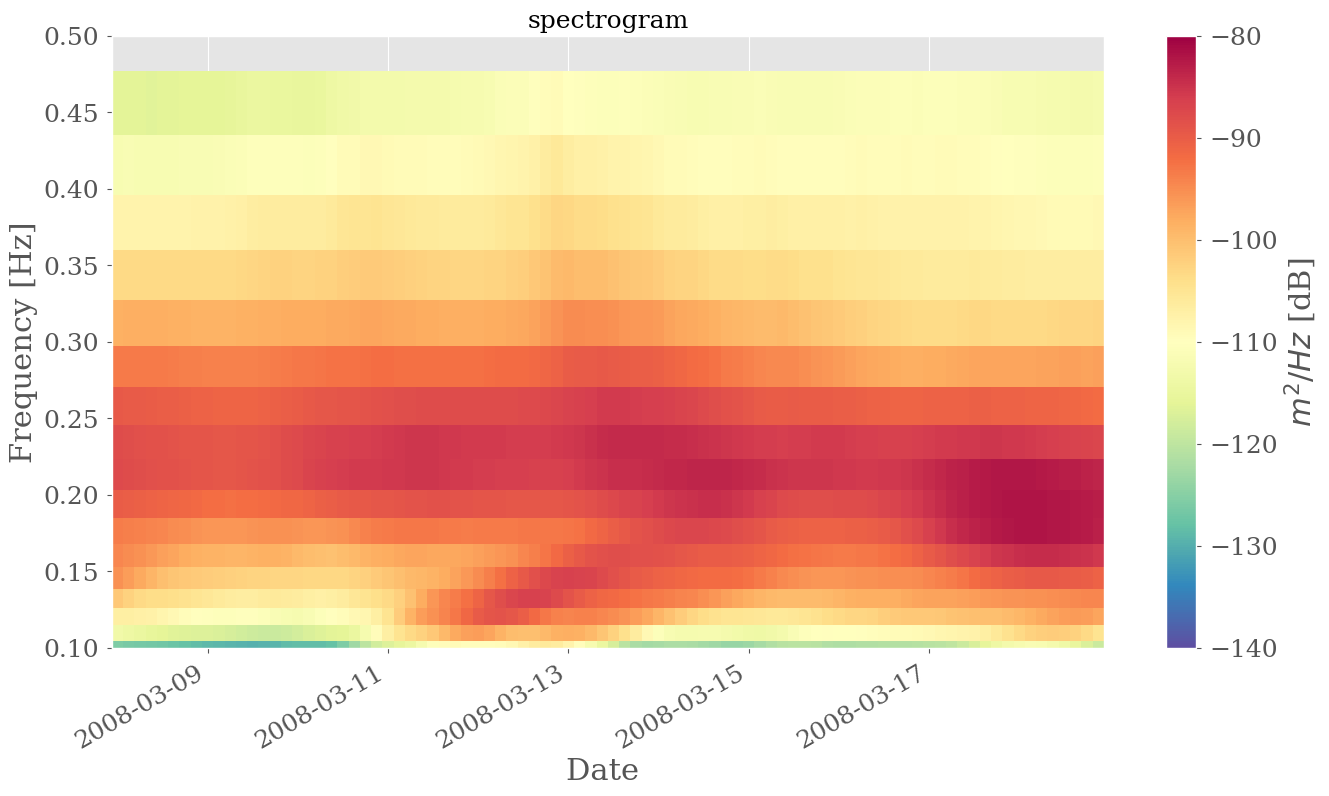

In [6]:
spectrogram(path_netcdf, dates, lon_sta=-158.011 , lat_sta=21.42 , Q=580)

## Real Data Comparison

Let's compare to real data. Here we computed the spectrogram for station IU.KIP, from the 8-19 March 2008. 

In [7]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.imaging.spectrogram import spectrogram

# Set Dates
t1 = UTCDateTime(start_date)
t2 = UTCDateTime(end_date)

# Request Data
client = Client("IRIS")
st = client.get_waveforms("IU", "KIP", "*", "LHZ", t1, t2, attach_response=True)
st.remove_response()
st.detrend()
tr_filt = st[0].copy()
tr_filt.filter('bandpass', freqmin=0.1, freqmax=0.45, corners=2, zerophase=True)  # Filter in Secondary Microseisms Frequency Range

IU.KIP.00.LHZ | 2008-03-08T00:00:00.385600Z - 2008-03-18T23:59:59.385600Z | 1.0 Hz, 950400 samples

(513, 1855)


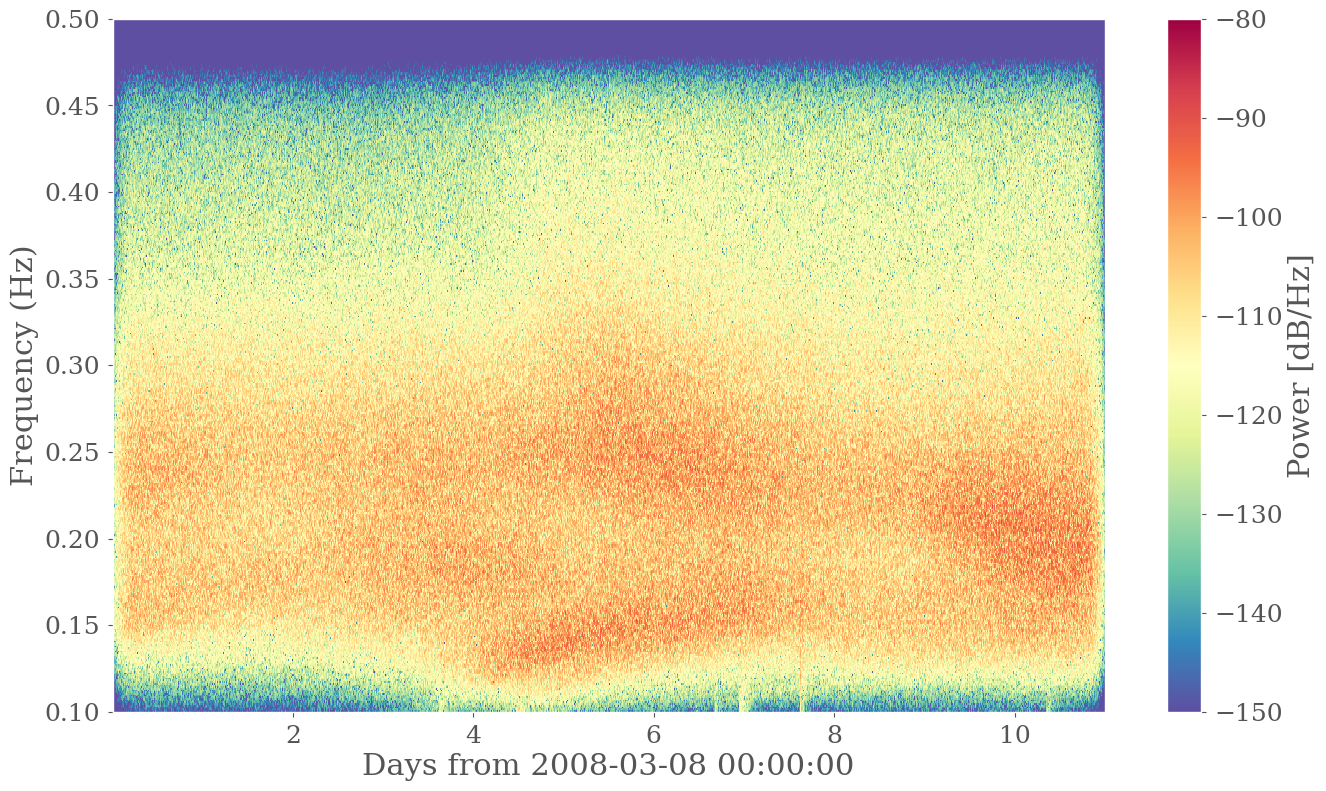

In [8]:
## Plot

import matplotlib.mlab as mlab
dt = st[0].stats.sampling_rate
npts = st[0].stats.npts
fe = 1/dt
nfft = 2**10
noverlap = nfft//2
# Spectrogram
(Px, freq, t) = mlab.specgram(tr_filt.data, Fs=fe, NFFT=nfft, noverlap=noverlap)
print(Px.shape)

plt.figure(figsize=(16,9))
plt.pcolormesh(t/3600/24, freq, 10*np.log10(Px), shading='auto', cmap='Spectral_r', vmin = -150, vmax = -80)
plt.colorbar(label='Power [dB/Hz]')
plt.ylim(0.1, 0.5)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Days from {}'.format(t1.datetime))
plt.savefig("spectrogram_KIP_real.png", dpi=350, bbox_inches='tight')